In [1]:
import cv2

## Preparing the Data for the model

There is too much data for us to read all at once in memory. We can use some built in functions in Keras to automatically process the data, generate a flow of batches from a directory, and also manipulate the images.

### Image Manipulation

Its usually a good idea to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. We can use the **ImageDataGenerator** to do this automatically for us. Check out the documentation for a full list of all the parameters you can use here!

In [2]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [3]:
image_gen = ImageDataGenerator(#rotation_range=30, # rotate the image 30 degrees
                               #width_shift_range=0.1, # Shift the pic width by a max of 10%
                               #height_shift_range=0.1, # Shift the pic height by a max of 10%
                               rescale=1/255, # Rescale the image by normalzing it.
                               #shear_range=0.2, # Shear means cutting away part of the image (max 20%)
                               #zoom_range=0.2, # Zoom in by 20% max
                               horizontal_flip=True, # Allo horizontal flipping
                               #fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [4]:
#image_gen.flow_from_directory('positions/train')
image_gen.flow_from_directory('actions/train')

Found 558 images belonging to 3 classes.


In [5]:
image_gen.flow_from_directory('actions/test')

Found 149 images belonging to 3 classes.


### Resizing Images

Let's have Keras resize all the images to 150 pixels by 150 pixels once they've been manipulated.

In [6]:
# width,height,channels
image_shape = (150,150,3)

# Creating the Model

In [8]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [9]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(150,150,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(150,150,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(150,150,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer, not binary!
model.add(Dense(3))
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy', #not binary for the poses
              optimizer='rmsprop',
              metrics=['accuracy'])

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)             0         
__________

### Training the Model

In [11]:
batch_size = 16

train_image_gen = image_gen.flow_from_directory('actions/train',
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='categorical') #catagoricalnfor the poses

Found 558 images belonging to 3 classes.


In [6]:
#print(next(train_image_gen))
#train_image_gen.shape

In [12]:
test_image_gen = image_gen.flow_from_directory('actions/test',
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='categorical')

Found 149 images belonging to 3 classes.


In [13]:
train_image_gen.class_indices

{'fall': 0, 'onFeet': 1, 'sit': 2}

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
results = model.fit_generator(train_image_gen,epochs=10,
                              steps_per_epoch=150,
                              validation_data=test_image_gen,
                             validation_steps=12)

Epoch 1/10
150/150 [==============================] - 119s 796ms/step - loss: 0.4418 - acc: 0.8203 - val_loss: 0.5242 - val_acc: 0.8792
Epoch 2/10
150/150 [==============================] - 97s 646ms/step - loss: 0.1247 - acc: 0.9582 - val_loss: 0.5996 - val_acc: 0.8658
Epoch 3/10
150/150 [==============================] - 97s 647ms/step - loss: 0.0473 - acc: 0.9858 - val_loss: 0.7610 - val_acc: 0.8792
Epoch 4/10
150/150 [==============================] - 147s 979ms/step - loss: 0.0305 - acc: 0.9928 - val_loss: 0.7983 - val_acc: 0.8859
Epoch 5/10
 60/150 [===========>..................] - ETA: 1:01 - loss: 0.0065 - acc: 0.9990

In [15]:
model.save('model3.h5')

# Evaluating the Model

In [16]:
results.history['acc']

[0.8340300997862449,
 0.9577405855745451,
 0.9849624060150376,
 0.9899581589958159,
 0.9949832775919732,
 0.9962374581939799,
 0.999163179916318,
 0.9974916387959866,
 0.999163179916318,
 0.9983277591973244]

In [17]:
import matplotlib.pyplot as plt

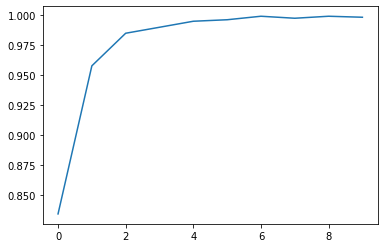

In [18]:
plt.plot(results.history['acc'])

In [19]:
from keras.models import load_model

In [20]:
new_model = load_model('binaryModel.h5')

# Predicting on new images

In [21]:
train_image_gen.class_indices

{'fall': 0, 'onFeet': 1}

In [36]:
import numpy as np
from keras.preprocessing import image

pose_file = 'testing/walk5.jpg'

pose = image.load_img(pose_file, target_size=(150, 150))

pose = image.img_to_array(pose)

pose = np.expand_dims(pose, axis=0) #so the network can think its a batch of one image
pose = pose/255

In [37]:
prediction_prob = new_model.predict(pose)
new_model.predict_classes(pose) 
                               

array([1])

In [34]:
# Output prediction
print(prediction_prob) #how sure is it that the image belongs to the array it chose 

[[1.7743273e-06 3.3431544e-07 1.8688984e-07 3.5053063e-02]]


In [22]:
import numpy as np
from keras.preprocessing import image
#function to classify a pose
def predictPose(imageName):
    #resize the image since the model is trained with 150 by 150 images
    pose = image.load_img(imageName, target_size=(150,150))
    pose = image.img_to_array(pose)
    pose = np.expand_dims(pose, axis=0)
    pose = pose/255
    
    #actual classification
    prediction_prob = new_model.predict(pose)
    #returns which pose
    poseNumber = new_model.predict_classes(pose)
    #print(prediction_prob)
    return poseNumber[0]+1
    
    

In [23]:
import time
import numpy as np
from PIL import Image
import os
import sys

In [24]:
def getAllImages(rootdir):
    """Gets all of the images in a folder and runs them through OpenPose.
    You just need to run this function with the folder of pose images"""
    path, dirs, files = next(os.walk(rootdir))
    file_count = len(files) - 1
    poseList = []
    action = 0
    actionList = []
    i = 0
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            # print os.path.join(subdir, file)
            filepath = subdir + os.sep + file

            if filepath.endswith(".jpg"):
                i += 1
                #printProgressBar(i + 1, file_count, prefix='Progress:', suffix='Complete', length=50)
                print("processing image "+ str(filepath))
                action = predictPose(filepath)
                print(action)
                actionList.append(action)
    return actionList
                

In [30]:
def calcPercentage(catagory,result):
    fall = 0
    onFeet = 0
    sit = 0
    size = len(result)
    for i in result:
        if i == 1:
            fall += 1
        elif i == 2:
            onFeet += 1
        elif i == 3:
            sit += 1
        else:
            print("error")
    print('Result of', size, catagory, 'images')
    print('fall:', fall, str((fall/size)*100)+'%')
   # print('sit:', sit, str((sit/size)*100)+'%')
    print('onFeet:', onFeet, str((onFeet/size)*100)+'%')

In [54]:
#testing falling
t = time.time()
print("Time at start: " + str((time.time() - t)))
fallingResult = getAllImages('testing/fall')
print("Time taken: " + str((time.time() - t)))

Time at start: 7.891654968261719e-05
processing image testing/fall/77.jpg
3
processing image testing/fall/89.jpg
1
processing image testing/fall/62.jpg
1
processing image testing/fall/60.jpg
2
processing image testing/fall/48.jpg
2
processing image testing/fall/49.jpg
2
processing image testing/fall/59.jpg
1
processing image testing/fall/71.jpg
1
processing image testing/fall/64.jpg
1
processing image testing/fall/8.jpg
1
processing image testing/fall/66.jpg
1
processing image testing/fall/99.jpg
1
processing image testing/fall/98.jpg
2
processing image testing/fall/73.jpg
1
processing image testing/fall/67.jpg
1
processing image testing/fall/9.jpg
1
processing image testing/fall/14.jpg
1
processing image testing/fall/28.jpg
1
processing image testing/fall/101.jpg
1
processing image testing/fall/115.jpg
1
processing image testing/fall/17.jpg
1
processing image testing/fall/116.jpg
1
processing image testing/fall/103.jpg
1
processing image testing/fall/117.jpg
3
processing image testing

In [49]:
#displaying results of falling
calcPercentage('falling', fallingResult)

Result of 100 falling images
total: 100
fall: 82 82.0
sit: 10 10.0
onFeet: 8 8.0


In [67]:
#displaying results of falling
calcPercentage('falling', fallingResult)

Result of 83 falling images
fall: 71 85.54216867469879%
sit: 4 4.819277108433735%
onFeet: 8 9.63855421686747%


In [56]:
#testing onFeet
t = time.time()
print("Time at start: " + str((time.time() - t)))
onFeetResult = getAllImages('testing/onFeet')
print("Time taken: " + str((time.time() - t)))

Time at start: 7.82012939453125e-05
processing image testing/onFeet/63.jpg
2
processing image testing/onFeet/77.jpg
1
processing image testing/onFeet/162.jpg
2
processing image testing/onFeet/62.jpg
2
processing image testing/onFeet/60.jpg
2
processing image testing/onFeet/149.jpg
2
processing image testing/onFeet/161.jpg
2
processing image testing/onFeet/160.jpg
2
processing image testing/onFeet/148.jpg
2
processing image testing/onFeet/49.jpg
2
processing image testing/onFeet/61.jpg
2
processing image testing/onFeet/59.jpg
2
processing image testing/onFeet/71.jpg
2
processing image testing/onFeet/65.jpg
2
processing image testing/onFeet/158.jpg
2
processing image testing/onFeet/159.jpg
2
processing image testing/onFeet/64.jpg
1
processing image testing/onFeet/70.jpg
2
processing image testing/onFeet/58.jpg
2
processing image testing/onFeet/8.jpg
2
processing image testing/onFeet/66.jpg
2
processing image testing/onFeet/72.jpg
2
processing image testing/onFeet/73.jpg
1
processing imag

In [51]:
#displaying results of onFeet
calcPercentage('onFeet', onFeetResult)

Result of 98 onFeet images
total: 98
fall: 11 11.224489795918368
sit: 2 2.0408163265306123
onFeet: 85 86.73469387755102


In [66]:
#displaying results of onFeet
calcPercentage('onFeet', onFeetResult)

Result of 87 onFeet images
fall: 6 6.896551724137931%
sit: 1 1.1494252873563218%
onFeet: 80 91.95402298850574%


In [58]:
#testing sitting
t = time.time()
print("Time at start: " + str((time.time() - t)))
sitResult = getAllImages('testing/sit')
print("Time taken: " + str((time.time() - t)))

Time at start: 7.772445678710938e-05
processing image testing/sit/228.jpg
3
processing image testing/sit/214.jpg
3
processing image testing/sit/229.jpg
3
processing image testing/sit/217.jpg
3
processing image testing/sit/216.jpg
3
processing image testing/sit/212.jpg
3
processing image testing/sit/213.jpg
3
processing image testing/sit/211.jpg
3
processing image testing/sit/221.jpg
3
processing image testing/sit/222.jpg
3
processing image testing/sit/223.jpg
3
processing image testing/sit/227.jpg
3
processing image testing/sit/226.jpg
3
processing image testing/sit/230.jpg
3
processing image testing/sit/224.jpg
3
processing image testing/sit/218.jpg
3
processing image testing/sit/219.jpg
3
Time taken: 0.6856949329376221


In [53]:
#displaying results of sitting
calcPercentage('sitting', sitResult)

Result of 20 sitting images
total: 20
fall: 1 5.0
sit: 18 90.0
onFeet: 1 5.0


In [68]:
#displaying results of sitting
calcPercentage('sitting', sitResult)

Result of 17 sitting images
fall: 0 0.0%
sit: 17 100.0%
onFeet: 0 0.0%


In [26]:
#testing falling (binary)
t = time.time()
print("Time at start: " + str((time.time() - t)))
fallingResult = getAllImages('testing/fall')
print("Time taken: " + str((time.time() - t)))

Time at start: 5.1021575927734375e-05
processing image testing/fall/77.jpg
2
processing image testing/fall/89.jpg
1
processing image testing/fall/62.jpg
1
processing image testing/fall/60.jpg
2
processing image testing/fall/48.jpg
2
processing image testing/fall/49.jpg
2
processing image testing/fall/59.jpg
1
processing image testing/fall/71.jpg
1
processing image testing/fall/64.jpg
1
processing image testing/fall/8.jpg
1
processing image testing/fall/66.jpg
1
processing image testing/fall/99.jpg
1
processing image testing/fall/98.jpg
2
processing image testing/fall/73.jpg
1
processing image testing/fall/67.jpg
1
processing image testing/fall/9.jpg
1
processing image testing/fall/14.jpg
1
processing image testing/fall/28.jpg
1
processing image testing/fall/101.jpg
1
processing image testing/fall/115.jpg
1
processing image testing/fall/17.jpg
1
processing image testing/fall/116.jpg
1
processing image testing/fall/103.jpg
1
processing image testing/fall/117.jpg
1
processing image testin

In [32]:
#displaying results of falling
calcPercentage('falling', fallingResult)

Result of 83 falling images
fall: 72 86.74698795180723%
onFeet: 11 13.253012048192772%


In [28]:
#testing falling (binary)
t = time.time()
print("Time at start: " + str((time.time() - t)))
onFeetResult = getAllImages('testing/onFeet')
print("Time taken: " + str((time.time() - t)))

Time at start: 5.1021575927734375e-05
processing image testing/onFeet/63.jpg
2
processing image testing/onFeet/77.jpg
1
processing image testing/onFeet/162.jpg
2
processing image testing/onFeet/62.jpg
2
processing image testing/onFeet/60.jpg
2
processing image testing/onFeet/149.jpg
2
processing image testing/onFeet/161.jpg
2
processing image testing/onFeet/160.jpg
2
processing image testing/onFeet/148.jpg
2
processing image testing/onFeet/49.jpg
2
processing image testing/onFeet/61.jpg
2
processing image testing/onFeet/59.jpg
2
processing image testing/onFeet/71.jpg
2
processing image testing/onFeet/65.jpg
2
processing image testing/onFeet/158.jpg
2
processing image testing/onFeet/159.jpg
2
processing image testing/onFeet/64.jpg
1
processing image testing/onFeet/70.jpg
2
processing image testing/onFeet/58.jpg
2
processing image testing/onFeet/8.jpg
1
processing image testing/onFeet/66.jpg
2
processing image testing/onFeet/72.jpg
2
processing image testing/onFeet/73.jpg
1
processing im

In [31]:
#displaying results of falling
calcPercentage('onFeet', onFeetResult)

Result of 87 onFeet images
fall: 7 8.045977011494253%
onFeet: 80 91.95402298850574%


In [41]:
import os.path
def detectAllPlayers():
    path = 'players/player'
    detected_poses = []
    player = 0
    pose = 0
    #to check if the player exists
    playerExists = os.path.isfile(path+str(player)+'.jpg') 

    while playerExists:
        pose = predictPose(path+str(player)+'.jpg')
        detected_poses.append(pose)
        player +=1
        playerExists = os.path.isfile(path+str(player)+'.jpg')   

    return detected_poses

In [47]:
#game play
def simonSays(correctPose):
    playerPoses = detectAllPlayers()
    for player in range(len(playerPoses)):
        if playerPoses[player] == correctPose:
            print("Player", player, "congrats! You've done the pose correctly")
        else:
            print("Player", player, "uh-oh! You've done the pose incorrectly")
    
